In [1]:
import pandas as pd
import plotnine as p9
import math
import numpy as np

In [2]:
exp_dir = '/scratch/pawsey0864/anicolson/experiments'

In [3]:
configs = [
    {'config': 'test_huggingface_single', 'trial': 0},
    {'config': 'test_huggingface_variable', 'trial': 0},
    {'config': 'test_huggingface_longitudinal_gt_prompt', 'trial': 0},
    {'config': 'test_huggingface_longitudinal_gen_prompt', 'trial': 0},
    {'config': 'test_huggingface_longitudinal_gen_prompt_cxr-bert', 'trial': 0},
]

In [4]:
from dlhpcstarter.utils import get_config_max_epochs


df = get_config_max_epochs(configs, 'cxrmate', exp_dir)
df['trial'] = pd.Categorical(df['trial'])
plt = (
        p9.ggplot(df, p9.aes(x='config', y='epoch', fill='trial'))
        + p9.geom_col(stat='identity', position='dodge')
        + p9.geom_text(p9.aes(label='epoch'),
             position=p9.position_dodge(width=0.9),
             size=8, va='bottom', format_string='{}')
        + p9.xlab('Configuration') + p9.ylab('Epochs')
        + p9.theme(axis_text_x=p9.element_text(rotation=90))
    )
_ = plt.draw()

In [5]:
from dlhpcstarter.utils import get_melted_config_test_scores


df = get_melted_config_test_scores(configs, 'cxrmate', exp_dir)
df.head()

,config,trial,metric,score
0,test_huggingface_single,0,test_report_nlg_num_study_ids,1624.0
1,test_huggingface_variable,0,test_report_nlg_num_study_ids,1624.0
2,test_huggingface_longitudinal_gen_prompt,0,test_report_nlg_num_study_ids,1624.0
3,test_huggingface_single,0,test_report_nlg_num_dicom_ids,2872.0
4,test_huggingface_variable,0,test_report_nlg_num_dicom_ids,NaN


In [6]:
metrics = {
    'test_report_chexbert_f1_macro': 'CheXbert F1',
    # 'test_report_chexbert_precision_macro': 'CheXbert Precision',
    # 'test_report_chexbert_recall_macro': 'CheXbert Recall',
    # 'test_report_radgraph_rg_er': 'RadGraph ER',
    'test_report_cxr-bert': 'CXR-BERT',
    'test_report_nlg_cider': 'CIDEr',
    'test_report_nlg_meteor': 'METEOR',
    'test_report_nlg_rouge': 'ROUGE-L',
    'test_report_nlg_bleu_4': 'B4',
}
df = df[df['metric'].isin(list(metrics.keys()))].copy()
df['metric'] = df['metric'].replace(metrics)
df['metric'] = pd.Categorical(df['metric'], categories=list(metrics.values()))
df.head()


,config,trial,metric,score
15,test_huggingface_single,0,B4,0.061085
16,test_huggingface_variable,0,B4,0.065262
17,test_huggingface_longitudinal_gen_prompt,0,B4,0.067683
18,test_huggingface_single,0,METEOR,0.142626
19,test_huggingface_variable,0,METEOR,0.147373


In [7]:
replace_dict = {i['config']: i['name'] if 'name' in i else i['config'] for i in configs}
df.replace({'config': replace_dict}, inplace=True)
df['config'] = pd.Categorical(df['config'], categories=list(replace_dict.values()))
df.head()

,config,trial,metric,score
15,test_huggingface_single,0,B4,0.061085
16,test_huggingface_variable,0,B4,0.065262
17,test_huggingface_longitudinal_gen_prompt,0,B4,0.067683
18,test_huggingface_single,0,METEOR,0.142626
19,test_huggingface_variable,0,METEOR,0.147373


In [8]:
df_mean = df.drop(['trial'], axis=1).groupby(['config', 'metric']).mean().reset_index()
df_std = df.drop(['trial'], axis=1).groupby(['config', 'metric']).std().reset_index()
df_std['y_min'] = df_mean['score'].values - df_std['score']
df_std['y_max'] = df_mean['score'].values + df_std['score']

plt = (
        p9.ggplot()
        + p9.geom_errorbar(df_std, p9.aes(x='config', ymin='y_min', ymax='y_max'), color='#666666')
        + p9.geom_point(df_mean, p9.aes(x='config', y='score', fill='config'), size=3.5, color='#666666', show_legend=False)
        + p9.geom_jitter(df, p9.aes(
            x='config', y='score', fill='config'), size=2.0, width=0.15, height=0.0, alpha=0.7, stroke=0.1, show_legend=False,
        )
        + p9.facet_wrap(['metric'], ncol=4, scales='free_x')
        # + p9.scale_y_continuous(breaks=breaks, labels=lambda x: [("%.2f" % y).lstrip('0') for y in x])
        + p9.theme_minimal()
        + p9.theme(subplots_adjust={'hspace': 0.3, 'wspace': 0.05}, figure_size=(15, 5)) # 7.5, 0.8
        + p9.coord_flip() + p9.xlab('') + p9.ylab('')
    )
# _ = plt.save('pdf/task_results.pdf', bbox_inches='tight', pad_inches=0)
_ = plt.draw()

/software/projects/pawsey0864/anicolson/environments/multimodal_23/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_errorbar : Removed 30 rows containing missing values.
/software/projects/pawsey0864/anicolson/environments/multimodal_23/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_point : Removed 12 rows containing missing values.
/software/projects/pawsey0864/anicolson/environments/multimodal_23/lib/python3.10/site-packages/plotnine/themes/themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


/software/projects/pawsey0864/anicolson/environments/multimodal_23/lib/python3.10/site-packages/plotnine/themes/themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


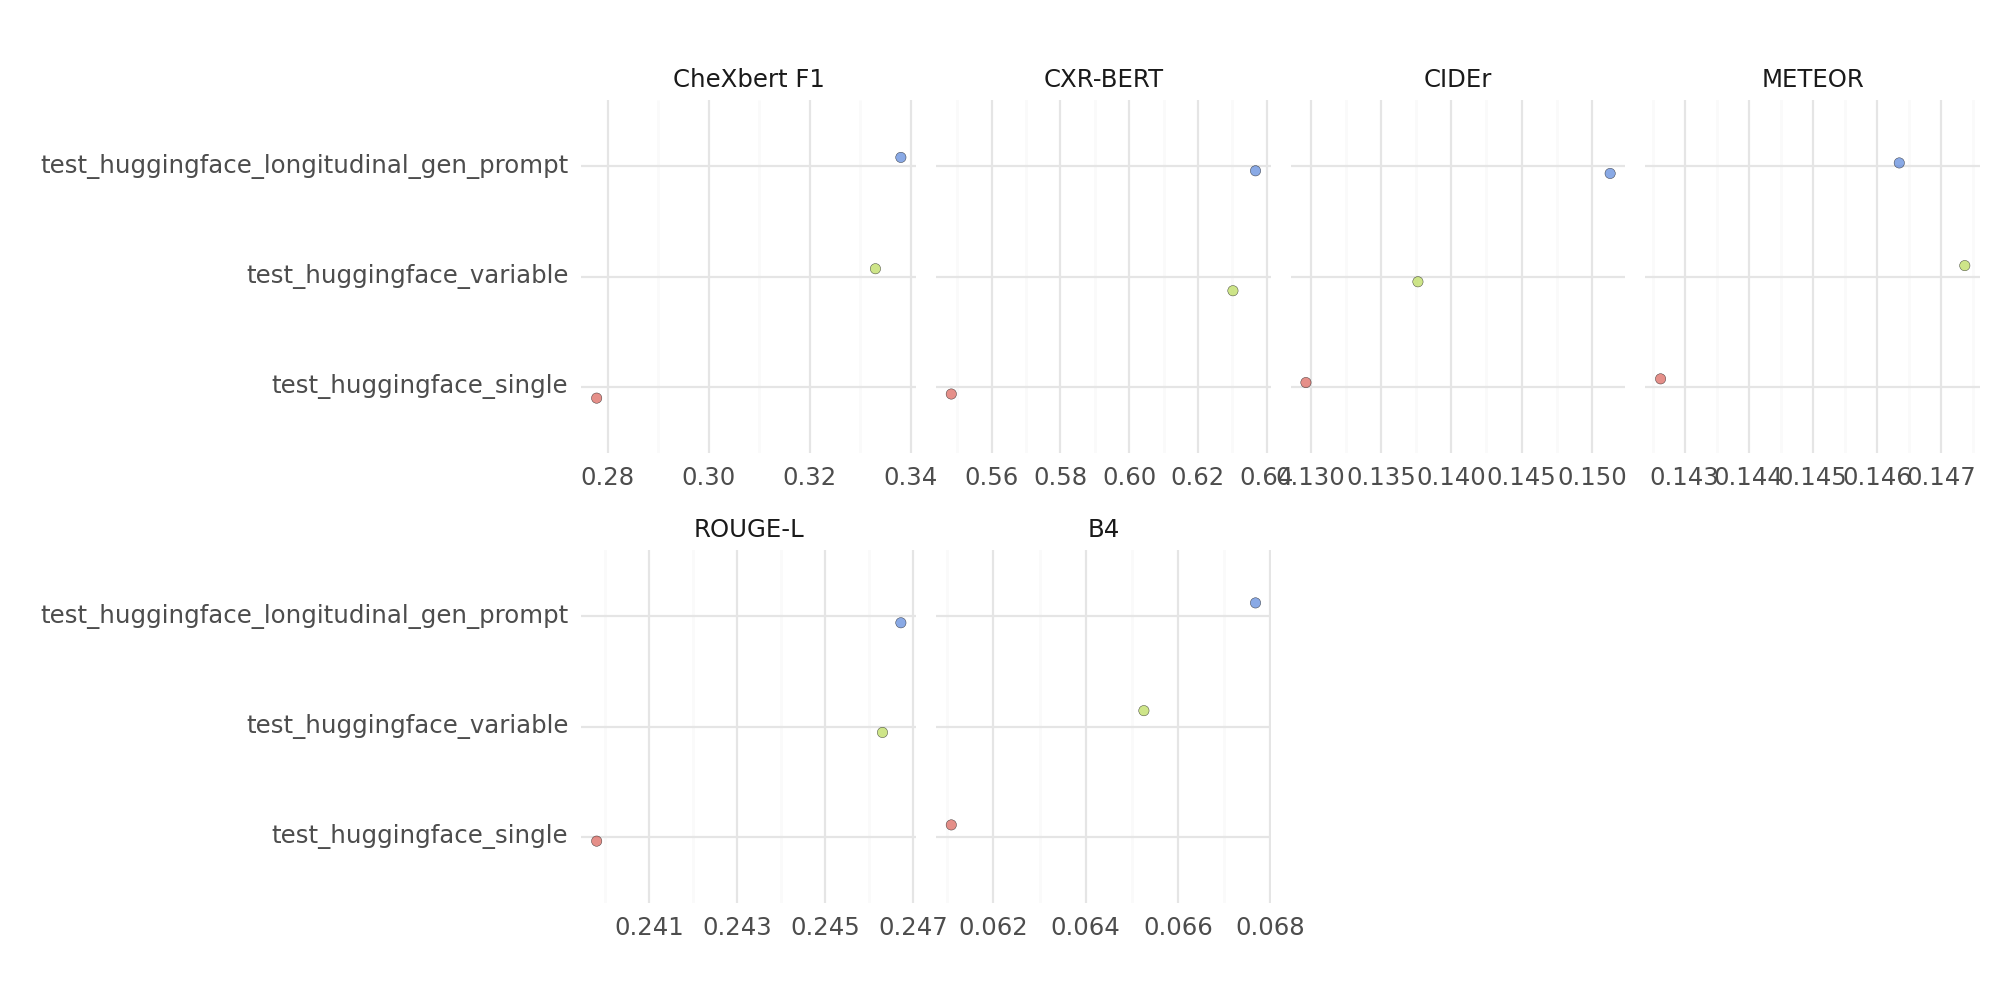

<Figure Size: (1000 x 500)>

In [9]:
def breaks(limits):
    decimals = 2
    factor = 10 ** decimals
    lower_limit = math.ceil(limits[0] * factor) / factor
    upper_limit = math.floor(limits[1] * factor) / factor

    fraction = 10**-decimals
    for spacing in np.arange(fraction, 1, fraction):
        break_points = np.arange(lower_limit, upper_limit + spacing, spacing).tolist()
        if len(break_points) <= 5:
            break
    return break_points

(
    p9.ggplot()
    # + p9.geom_errorbar(df_std, p9.aes(x='config', ymin='y_min', ymax='y_max'), color='#666666')
    # + p9.geom_point(df_mean, p9.aes(x='config', y='score', fill='config'), size=3.5, color='#666666', show_legend=False)
    + p9.geom_jitter(df, p9.aes(
        x='config', y='score', fill='config'), size=2.0, width=0.15, height=0.0, alpha=0.7, stroke=0.1, show_legend=False,
    )
    + p9.facet_wrap(['metric'], ncol=4, scales='free_x')
    # + p9.scale_y_continuous(breaks=breaks, labels=lambda x: [("%.2f" % y).lstrip('0') for y in x])
    + p9.theme_minimal()
    + p9.theme(subplots_adjust={'hspace': 0.3, 'wspace': 0.05}, figure_size=(10, 5))
    + p9.coord_flip() + p9.xlab('') + p9.ylab('')
)
